In [1]:
import os
import warnings
import re
import random
import math
import pandas as pd
import numpy as np
import scipy
import sklearn

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from pylab import rcParams

In [4]:
feeds_df = pd.read_csv(os.getcwd() + '/Datasets/feeds_df_for_reco.csv')
feeds_df['createdAt'] = pd.to_datetime(feeds_df['createdAt'])
feeds_df['updatedAt'] = pd.to_datetime(feeds_df['updatedAt'])
feeds_df = feeds_df[~feeds_df['text'].isna()]
print(feeds_df.shape)
feeds_df.head()

(2555, 13)


,contentId,anonymous,authorId,createdAt,isActive,isDelete,points,text,type,updatedAt,resource_link,resource_videoUrl,resource_image
0,5eaa8499d9e8980022200604,False,5ea238633ae1b80048f4f43c,2020-04-30 07:56:09.909,True,False,0.222222,Balance #Negotiation Power Negotiation requir...,POST,2020-04-30 08:34:36.795,[{'url': 'https://www.linkedin.com/pulse/crash...,[],[]
1,5eabae544bc32c003663b786,False,5eabad0e9890ea0050e7c800,2020-05-01 05:06:28.767,True,False,0.235294,"Hi guys, I am a chemical Engineer. But my pass...",POST,2020-05-01 09:33:16.347,[],[],[]
2,5eaa94e911914b00283bcaf5,False,5eaa928fd9e8980022200613,2020-04-30 09:05:45.211,True,False,0.888889,@ShitalKakad Which Indian food to include in t...,QUESTION,2020-05-13 02:38:07.669,[],[],[]
3,5eaad78e11914b00283bcb25,False,5ea974f75e00240036a11833,2020-04-30 13:50:06.761,True,False,1.647059,Hello everyone. Looking forward to connect wit...,POST,2020-05-01 08:14:41.114,[],[],[]
4,5eac79d6bfe8020026a3bc63,False,5eac5a685ed505002290ca9b,2020-05-01 19:34:46.428,True,False,0.937500,Hey me Ankita ..I want to get work from home j...,POST,2020-05-17 20:33:23.220,[],[],[]


# Interactions Data

In [5]:
likes_df = pd.read_csv(os.getcwd() + '/Datasets/likes_coll_df.csv')
likes_df['createdAt'] = pd.to_datetime(likes_df['createdAt'])
likes_df['updatedAt'] = pd.to_datetime(likes_df['updatedAt'])
likes_df = likes_df[likes_df['type'] != 'ARTICLE']
print(likes_df.shape)
likes_df.head(1)

(6866, 9)


,likeId,commentId,createdAt,emojiType,isActive,referenceId,type,updatedAt,userId
0,5df502726c5e063edec6360b,5df4b061a68eb700165a664a,2019-12-14 15:40:34.645,Like,True,NaN,COMMENT,2019-12-14 15:40:34.645,5df45b5b7e4ea600161b8ede


In [6]:
comments_df = pd.read_csv(os.getcwd() + '/Datasets/comments_df.csv')
comments_df['createdAt'] = pd.to_datetime(comments_df['createdAt'])
print(comments_df.shape)
comments_df.head(1)

(7241, 8)


,commentId,authorId,createdAt,isActive,isSubComment,referenceId,type,comment_text
0,5df47e0b7e4ea600161b94b3,5df45cf27e4ea600161b8f13,2019-12-14 06:15:39.413,True,False,5df4699b7e4ea600161b913e,QUESTION,Hi Pihu. I strongly believe you should start y...


In [7]:
bookmarks_df = pd.read_csv(os.getcwd() + '/Datasets/bookmarks_coll_df.csv')
bookmarks_df['createdAt'] = pd.to_datetime(bookmarks_df['createdAt'])
bookmarks_df['updatedAt'] = pd.to_datetime(bookmarks_df['updatedAt'])
bookmarks_df = bookmarks_df[bookmarks_df['type'] != 'COMPANY']
print(bookmarks_df.shape)
bookmarks_df.head(1)

(249, 7)


,bookmarkId,createdAt,isActive,referenceFeedId,type,updatedAt,userId
0,5e5e1df0038098664944f081,2020-03-03 09:05:52.348,True,5e5e195568860c00163d49db,POST,2020-03-16 09:37:54.993,5df4c077a68eb700165a66c3


In [8]:
post_likes_df = likes_df[likes_df['type'] != 'COMMENT']
print(post_likes_df.shape)
post_likes_df = post_likes_df[['likeId', 'referenceId', 'userId', 'createdAt', 'type']]
post_likes_df = post_likes_df.rename(columns = {'likeId':'eventId', 'referenceId':'contentId', 'userId':'personId'})
post_likes_df['eventType'] = 'LIKE'

(3749, 9)


In [9]:
likes_df_formatted = post_likes_df
likes_df_formatted.head(1)

,eventId,contentId,personId,createdAt,type,eventType
1,5df475d96c5e063edebdc43b,5df457ad7e4ea600161b8e6b,5df45f167e4ea600161b8f7a,2019-12-14 05:40:41.806,QUESTION,LIKE


In [10]:
comments_df_formatted = comments_df[['commentId', 'referenceId', 'authorId', 'createdAt', 'type', 'isSubComment']]
comments_df_formatted = comments_df_formatted.rename(columns = {'commentId':'eventId', 'referenceId':'contentId', 'authorId':'personId'})
comments_df_formatted['eventType'] = np.where(comments_df_formatted['isSubComment'] == False, 'COMMENT', 'SUBCOMMENT')
comments_df_formatted = comments_df_formatted.drop(['isSubComment'], axis=1)
comments_df_formatted.head(1)


,eventId,contentId,personId,createdAt,type,eventType
0,5df47e0b7e4ea600161b94b3,5df4699b7e4ea600161b913e,5df45cf27e4ea600161b8f13,2019-12-14 06:15:39.413,QUESTION,COMMENT


In [11]:
bookmarks_df_formatted = bookmarks_df[['bookmarkId', 'referenceFeedId', 'userId', 'createdAt', 'type']]
bookmarks_df_formatted = bookmarks_df_formatted.rename(columns = {'bookmarkId':'eventId', 'referenceFeedId':'contentId', 'userId':'personId'})
bookmarks_df_formatted['eventType'] = 'BOOKMARK'
bookmarks_df_formatted.head(1)

,eventId,contentId,personId,createdAt,type,eventType
0,5e5e1df0038098664944f081,5e5e195568860c00163d49db,5df4c077a68eb700165a66c3,2020-03-03 09:05:52.348,POST,BOOKMARK


In [12]:
feeds_df.head(1)

,contentId,anonymous,authorId,createdAt,isActive,isDelete,points,text,type,updatedAt,resource_link,resource_videoUrl,resource_image
0,5eaa8499d9e8980022200604,False,5ea238633ae1b80048f4f43c,2020-04-30 07:56:09.909,True,False,0.222222,Balance #Negotiation Power Negotiation requir...,POST,2020-04-30 08:34:36.795,[{'url': 'https://www.linkedin.com/pulse/crash...,[],[]


In [13]:
written_post_df_formatted = feeds_df[['contentId', 'authorId', 'createdAt', 'type']].copy()
written_post_df_formatted['eventId'] = written_post_df_formatted['contentId']
written_post_df_formatted = written_post_df_formatted.rename(columns = {'authorId':'personId'})
written_post_df_formatted = written_post_df_formatted[['eventId', 'contentId', 'personId', 'createdAt', 'type']]
written_post_df_formatted['eventType'] = 'CREATE POST'
written_post_df_formatted.head(1)

,eventId,contentId,personId,createdAt,type,eventType
0,5eaa8499d9e8980022200604,5eaa8499d9e8980022200604,5ea238633ae1b80048f4f43c,2020-04-30 07:56:09.909,POST,CREATE POST


In [14]:
interactions_df = likes_df_formatted.append([comments_df_formatted, bookmarks_df_formatted, written_post_df_formatted])
print(interactions_df.shape)
interactions_df.head(1)

(13794, 6)


,eventId,contentId,personId,createdAt,type,eventType
1,5df475d96c5e063edebdc43b,5df457ad7e4ea600161b8e6b,5df45f167e4ea600161b8f7a,2019-12-14 05:40:41.806,QUESTION,LIKE


In [15]:
#Removing content from interactions whih are not present in Feed data
interactions_df = interactions_df[interactions_df['contentId'].isin(feeds_df['contentId'])]
print(interactions_df.shape)
interactions_df.head(1)

(13639, 6)


,eventId,contentId,personId,createdAt,type,eventType
1,5df475d96c5e063edebdc43b,5df457ad7e4ea600161b8e6b,5df45f167e4ea600161b8f7a,2019-12-14 05:40:41.806,QUESTION,LIKE


In [16]:
interaction_summary = interactions_df.groupby(['personId'])['contentId'].nunique().reset_index()
interaction_summary.columns = ['personId', 'content_ct']
interaction_summary = interaction_summary.sort_values(['content_ct'], ascending=False)
print("Total Users:", interaction_summary.shape)
print("Users with more than 1 content interaction:", interaction_summary[interaction_summary['content_ct']>1].shape)
interaction_summary.head(1)


Total Users: (2180, 2)
Users with more than 1 content interaction: (897, 2)


,personId,content_ct
0,5df38de0b2694d0016bdb71f,567


In [17]:
first_interaction = interactions_df.groupby(['personId', 'contentId'])['createdAt'].min().reset_index()
first_interaction['rank'] = first_interaction.groupby(['personId'])['createdAt'].rank(method="first", ascending = False)

content_count = first_interaction.groupby(['personId'])['contentId'].count().reset_index()
content_count.columns = ['personId', 'content_count']

first_interaction = pd.merge(first_interaction, content_count, how = 'left', on = ['personId'])

max_rank = first_interaction.groupby(['personId'])['rank'].max().reset_index()
max_rank.columns = ['personId', 'max_rank']

first_interaction = pd.merge(first_interaction, max_rank, how = 'left', on = ['personId'])
first_interaction['rank_proportion'] = (first_interaction['rank']/first_interaction['max_rank'])*100

first_interaction['interaction_category'] = np.where(first_interaction['content_count'] == 1, 'Single', 'Multi')

first_interaction.head()

,personId,contentId,createdAt,rank,content_count,max_rank,rank_proportion,interaction_category
0,5df38de0b2694d0016bdb71f,5df7222ed092c70016203257,2019-12-12 21:54:00,282.0,567,567.0,49.735450,Multi
1,5df38de0b2694d0016bdb71f,5df72230d092c7001620325d,2019-12-12 21:54:00,283.0,567,567.0,49.911817,Multi
2,5df38de0b2694d0016bdb71f,5df72233d092c70016203263,2019-12-12 21:54:00,284.0,567,567.0,50.088183,Multi
3,5df38de0b2694d0016bdb71f,5df72235d092c7001620326a,2019-12-12 21:54:00,285.0,567,567.0,50.264550,Multi
4,5df38de0b2694d0016bdb71f,5df72238d092c70016203271,2019-12-12 21:54:00,286.0,567,567.0,50.440917,Multi


In [18]:
first_interaction_multi = first_interaction[first_interaction['interaction_category'] == 'Multi'].copy()

def custom_train_test_func(df):
    if( (df['content_count']<=4) & (df['rank']==1.0) ):
        return('Test')
    if( (df['content_count']>4) & (df['rank_proportion']<=20.00000) & (df['rank']<=10.0) ):
        return('Test')
    else:
        return('Train')

first_interaction_multi['train_test'] = first_interaction_multi.apply(custom_train_test_func, axis=1)
#first_interaction['train_test'] = np.where((first_interaction['interaction_category']=='Multi') & (first_interaction['rank_proportion']<=33.33333), "Test", "Train")
first_interaction_multi.head(5)

,personId,contentId,createdAt,rank,content_count,max_rank,rank_proportion,interaction_category,train_test
0,5df38de0b2694d0016bdb71f,5df7222ed092c70016203257,2019-12-12 21:54:00,282.0,567,567.0,49.735450,Multi,Train
1,5df38de0b2694d0016bdb71f,5df72230d092c7001620325d,2019-12-12 21:54:00,283.0,567,567.0,49.911817,Multi,Train
2,5df38de0b2694d0016bdb71f,5df72233d092c70016203263,2019-12-12 21:54:00,284.0,567,567.0,50.088183,Multi,Train
3,5df38de0b2694d0016bdb71f,5df72235d092c7001620326a,2019-12-12 21:54:00,285.0,567,567.0,50.264550,Multi,Train
4,5df38de0b2694d0016bdb71f,5df72238d092c70016203271,2019-12-12 21:54:00,286.0,567,567.0,50.440917,Multi,Train


In [19]:
print('Train', first_interaction_multi[first_interaction_multi['train_test']=='Train'].shape)
print('Test', first_interaction_multi[first_interaction_multi['train_test']=='Test'].shape)

Train (7450, 9)
Test (1490, 9)


# Data Wrangling

In [20]:
event_type_strength = {
#   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 2.5, 
#   'FOLLOW': 3.0,
   'COMMENT': 4.0,
    'SUBCOMMENT': 4.0,
    'CREATE POST':5
}

interactions_df['eventStrength'] = interactions_df['eventType'].apply(lambda x: event_type_strength[x])

In [21]:
users_interactions_count_df = interactions_df.groupby(['personId', 'contentId']).size().groupby('personId').size()
print('# users: %d' % len(users_interactions_count_df))
users_with_1_interactions_df = users_interactions_count_df[users_interactions_count_df == 1].reset_index()[['personId']]
print('# users with 1 interactions: %d' % len(users_with_1_interactions_df))
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 2].reset_index()[['personId']]
print('# users with at least 2 interactions: %d' % len(users_with_enough_interactions_df))

# users: 2180
# users with 1 interactions: 1283
# users with at least 2 interactions: 897


In [22]:
print('# of interactions: %d' % len(interactions_df))
interactions_from_multi_inter_users_df = interactions_df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')
print('# of interactions from users with at least 2 interactions: %d' % len(interactions_from_multi_inter_users_df))

# of interactions: 13639
# of interactions from users with at least 2 interactions: 11787


In [23]:
print('# of interactions: %d' % len(interactions_df))
interactions_from_single_inter_users_df = interactions_df.merge(users_with_1_interactions_df, 
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')
print('# of interactions from users with 1 interaction: %d' % len(interactions_from_single_inter_users_df))

# of interactions: 13639
# of interactions from users with 1 interaction: 1852


In [24]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_multi_df = interactions_from_multi_inter_users_df \
                    .groupby(['personId', 'contentId'])['eventStrength'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_multi_df))
interactions_multi_df.head()

# of unique user/item interactions: 8940


,personId,contentId,eventStrength
0,5df38de0b2694d0016bdb71f,5df7222ed092c70016203257,2.584963
1,5df38de0b2694d0016bdb71f,5df72230d092c7001620325d,2.584963
2,5df38de0b2694d0016bdb71f,5df72233d092c70016203263,2.584963
3,5df38de0b2694d0016bdb71f,5df72235d092c7001620326a,2.584963
4,5df38de0b2694d0016bdb71f,5df72238d092c70016203271,2.584963


In [25]:
interactions_single_df = interactions_from_single_inter_users_df \
                    .groupby(['personId', 'contentId'])['eventStrength'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_single_df))
interactions_single_df.head()

# of unique user/item interactions: 1283


,personId,contentId,eventStrength
0,5df4582e7e4ea600161b8e75,5df45cdc7e4ea600161b8f0f,2.584963
1,5df459377e4ea600161b8e94,5df45c6e7e4ea600161b8efb,2.584963
2,5df45a5c7e4ea600161b8ebd,5df45e207e4ea600161b8f49,2.584963
3,5df45eea7e4ea600161b8f6f,5df45fed7e4ea600161b8fb0,2.584963
4,5df45feb7e4ea600161b8fad,5df461f77e4ea600161b8ff6,2.584963


In [26]:
full_interaction_df = interactions_multi_df.append(interactions_single_df)
full_interaction_df.head()

,personId,contentId,eventStrength
0,5df38de0b2694d0016bdb71f,5df7222ed092c70016203257,2.584963
1,5df38de0b2694d0016bdb71f,5df72230d092c7001620325d,2.584963
2,5df38de0b2694d0016bdb71f,5df72233d092c70016203263,2.584963
3,5df38de0b2694d0016bdb71f,5df72235d092c7001620326a,2.584963
4,5df38de0b2694d0016bdb71f,5df72238d092c70016203271,2.584963


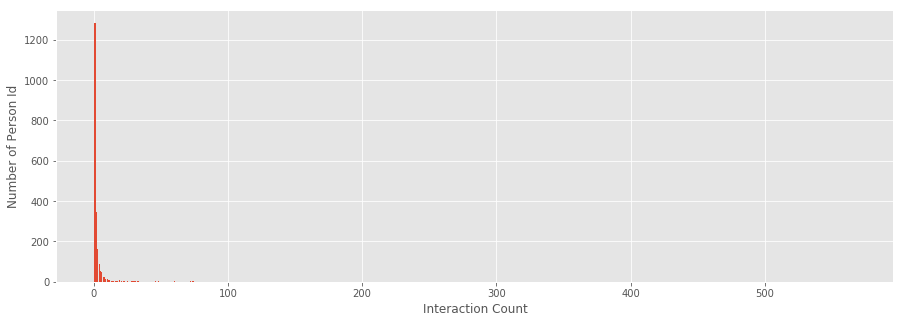

In [27]:
user_interaction_category = users_interactions_count_df.reset_index()
user_interaction_category.columns = ['personId', 'interaction_count']
user_interaction_category.head()

user_interaction_count_summary = user_interaction_category.groupby(['interaction_count'])['personId'].count().reset_index()

%matplotlib inline
rcParams['figure.figsize'] = 15, 5
plt.style.use('ggplot')
plt.bar(user_interaction_count_summary['interaction_count'], user_interaction_count_summary['personId'])
plt.xlabel("Interaction Count")
plt.ylabel("Number of Person Id")
plt.show()

In [28]:
def interaction_category_func(df):
    if(df['interaction_count'] == 1):
        return("1")
    if(df['interaction_count'] == 2):
        return("2")
    if((df['interaction_count'] > 2) & (df['interaction_count'] <= 5)):
        return("3 to 5")
    if((df['interaction_count'] > 5) & (df['interaction_count'] <= 10)):
        return("6 to 10")
    if((df['interaction_count'] > 10) & (df['interaction_count'] <= 50)):
        return("11 to 50")
    if(df['interaction_count'] > 50):
        return("More than 50")
    else:
        return(np.nan)

def interaction_ordering_func(df):
    if(df['interaction_count'] == 1):
        return(1)
    if(df['interaction_count'] == 2):
        return(2)
    if((df['interaction_count'] > 2) & (df['interaction_count'] <= 5)):
        return(3)
    if((df['interaction_count'] > 5) & (df['interaction_count'] <= 10)):
        return(4)
    if((df['interaction_count'] > 10) & (df['interaction_count'] <= 50)):
        return(5)
    if(df['interaction_count'] > 50):
        return(6)
    else:
        return(np.nan)
    
user_interaction_category['interaction_category'] = user_interaction_category.apply(interaction_category_func, axis = 1)
user_interaction_category['order'] = user_interaction_category.apply(interaction_ordering_func, axis = 1)
user_interaction_category.groupby(['order', 'interaction_category'])['personId'].count().reset_index()

,order,interaction_category,personId
0,1,1,1283
1,2,2,345
2,3,3 to 5,307
3,4,6 to 10,121
4,5,11 to 50,88
5,6,More than 50,36


# Evaluation

In [30]:
## Time Bound Sampling

interactions_multi_df_time = pd.merge(interactions_multi_df, first_interaction_multi[['personId', 'contentId', 'train_test']], how = 'left', on = ['personId', 'contentId'])
interactions_multi_df_time.head()

interactions_multi_train_df = interactions_multi_df_time[interactions_multi_df_time['train_test'] == 'Train']
interactions_multi_train_df = interactions_multi_train_df.drop(['train_test'], axis=1)

interactions_multi_test_df = interactions_multi_df_time[interactions_multi_df_time['train_test'] == 'Test']
interactions_multi_test_df = interactions_multi_test_df.drop(['train_test'], axis=1)

print('# interactions on Multi Train set: %d' % len(interactions_multi_train_df))
print('# interactions on Multi Test set (These are old customers with History): %d' % len(interactions_multi_test_df))


interactions_single_df_time = pd.merge(interactions_single_df, first_interaction[['personId', 'contentId', 'createdAt']], how = 'left', on = ['personId', 'contentId'])
interactions_single_df_time.head()

interactions_single_train_df = interactions_single_df_time[interactions_single_df_time['createdAt'] <= pd.to_datetime('2020-05-10')].copy()
interactions_single_train_df = interactions_single_train_df.drop(['createdAt'], axis=1)
interactions_single_test_df = interactions_single_df_time[interactions_single_df_time['createdAt'] > pd.to_datetime('2020-05-10')].copy()
interactions_single_test_df = interactions_single_test_df.drop(['createdAt'], axis=1)
print('# interactions on Single Train set: %d' % len(interactions_single_train_df))
print('# interactions on Single Test set (These are new customers with no History): %d' % len(interactions_single_test_df))


# interactions on Multi Train set: 7450
# interactions on Multi Test set (These are old customers with History): 1490
# interactions on Single Train set: 1050
# interactions on Single Test set (These are new customers with no History): 233


In [171]:
## Time Bound Sampling

#interactions_multi_df_time = pd.merge(interactions_multi_df, first_interaction, how = 'left', on = ['personId', 'contentId'])
#interactions_multi_df_time.head()

#interactions_multi_train_df = interactions_multi_df_time[interactions_multi_df_time['createdAt'] <= pd.to_datetime('2020-05-10')].copy()
#interactions_multi_train_df = interactions_multi_train_df.drop(['createdAt'], axis=1)
#interactions_multi_test_df = interactions_multi_df_time[interactions_multi_df_time['createdAt'] > pd.to_datetime('2020-05-10')].copy()
#interactions_multi_test_df = interactions_multi_test_df.drop(['createdAt'], axis=1)
#print('# interactions on Multi Train set: %d' % len(interactions_multi_train_df))
#print('# interactions on Multi Test set (These are old customers with History): %d' % len(interactions_multi_test_df))

#interactions_single_df_time = pd.merge(interactions_single_df, first_interaction, how = 'left', on = ['personId', 'contentId'])
#interactions_single_df_time.head()

#interactions_single_train_df = interactions_single_df_time[interactions_single_df_time['createdAt'] <= pd.to_datetime('2020-05-10')].copy()
#interactions_single_train_df = interactions_single_train_df.drop(['createdAt'], axis=1)
#interactions_single_test_df = interactions_single_df_time[interactions_single_df_time['createdAt'] > pd.to_datetime('2020-05-10')].copy()
#interactions_single_test_df = interactions_single_test_df.drop(['createdAt'], axis=1)
#print('# interactions on Single Train set: %d' % len(interactions_single_train_df))
#print('# interactions on Single Test set (These are new customers with no History): %d' % len(interactions_single_test_df))


In [29]:
## Random Sampling
# Take 20% random content as Test. 
# However perform stratified sampling on multi interaction user vs simple sampling for single interaction users
interactions_multi_train_df, interactions_multi_test_df = train_test_split(interactions_multi_df,
                                   stratify=interactions_multi_df['personId'], 
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Multi Train set: %d' % len(interactions_multi_train_df))
print('# interactions on Multi Test set (These are old customers with History): %d' % len(interactions_multi_test_df))

interactions_single_train_df, interactions_single_test_df = train_test_split(interactions_single_df,
                                   #stratify=interactions_multi_df['personId'], 
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Single Train set: %d' % len(interactions_single_train_df))
print('# interactions on Single Test set (These are new customers with no History): %d' % len(interactions_single_test_df))

# interactions on Multi Train set: 7152
# interactions on Multi Test set (These are old customers with History): 1788
# interactions on Single Train set: 1026
# interactions on Single Test set (These are new customers with no History): 257


In [30]:
#For standardisation of accuracy comparison across users limit the test case content to max 10 for each user
for_N_test_case = interactions_multi_test_df.copy()
for_N_test_case['rank'] = for_N_test_case.groupby(['personId'])['contentId'].apply(lambda x: x.rank())
for_N_test_case = for_N_test_case.sort_values(['personId', 'rank'], ascending = [True, True])

N_test_cases = for_N_test_case[for_N_test_case['rank']<=10].copy()
add_rest_to_train = for_N_test_case[for_N_test_case['rank']>10].copy()

N_test_cases = N_test_cases.drop(['rank'], axis=1)
add_rest_to_train = add_rest_to_train.drop(['rank'], axis=1)

print("N_test_cases: ", N_test_cases.shape)
print("add_rest_to_train: ", add_rest_to_train.shape)

N_test_cases:  (1274, 3)
add_rest_to_train:  (514, 3)


In [31]:
interactions_multi_train_df = interactions_multi_train_df.append(add_rest_to_train)
interactions_multi_test_df = N_test_cases

In [32]:
print('# interactions on Multi Train set: %d' % len(interactions_multi_train_df))
print('# interactions on Multi Test set (These are old customers with History): %d' % len(interactions_multi_test_df))

# interactions on Multi Train set: 7666
# interactions on Multi Test set (These are old customers with History): 1274


In [33]:
interactions_train_df = interactions_multi_train_df.append(interactions_single_train_df)
interactions_test_df = interactions_multi_test_df.append(interactions_single_test_df)

In [34]:
#Indexing by personId to speed up the searches during evaluation
#interactions_full_indexed_df = interactions_multi_df.set_index('personId')
#interactions_train_indexed_df = interactions_train_df.set_index('personId')
#interactions_test_indexed_df = interactions_test_df.set_index('personId')

In [35]:
#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = full_interaction_df.set_index('personId')
interactions_train_indexed_df = interactions_train_df.set_index('personId')
interactions_test_indexed_df = interactions_test_df.set_index('personId')
interactions_single_train_indexed_df = interactions_single_train_df.set_index('personId')
interactions_single_test_indexed_df = interactions_single_test_df.set_index('personId')
interactions_multi_train_indexed_df = interactions_multi_train_df.set_index('personId')

In [36]:
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

In [37]:
def get_items_interacted(person_id, interactions_df):
    # Get the user's data and merge in the movie information.
    if(((pd.Series(person_id).isin(pd.Series(interactions_df.index.unique().to_list()))) == True)[0]):
        interacted_items = interactions_df.loc[person_id]['contentId']
        return(set(interacted_items if type(interacted_items) == pd.Series else [interacted_items]))
    else:
        interacted_items = set()
        return(interacted_items)
    

In [38]:
def get_not_interacted_items_sample(person_id, sample_size, seed=42):
    interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
    all_items = set(feeds_df['contentId'])
    non_interacted_items = all_items - interacted_items

    random.seed(seed)
    non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
    return set(non_interacted_items_sample)

In [39]:
def _verify_hit_top_n(item_id, recommended_items, topn):
    try:
        index = next(i for i, c in enumerate(recommended_items) if c == item_id)
    except:
        index = -1
    hit = int(index in range(0, topn))
    return hit, index

In [40]:
#Customisation
def evaluate_model_for_user(model, person_id):
    #Getting the items in test set
    interacted_values_testset = interactions_test_indexed_df.loc[person_id]
    if type(interacted_values_testset['contentId']) == pd.Series:
        person_interacted_items_testset = set(interacted_values_testset['contentId'])
    else:
        person_interacted_items_testset = set([interacted_values_testset['contentId']])  
    interacted_items_count_testset = len(person_interacted_items_testset) 
    
    #Getting a ranked recommendation list from a model for a given user
    person_recs_df = model.recommend_items(person_id, 
                                         items_to_ignore=get_items_interacted(person_id, 
                                         interactions_train_indexed_df), 
                                         topn=1000000000)
    person_recs_df['personId'] = person_id
    top_100_reco = person_recs_df[0:100]
    
    hits_at_5_count = 0
    hits_at_10_count = 0
    #For each item the user has interacted in test set
    for item_id in person_interacted_items_testset:
        #Getting a random sample (100) items the user has not interacted 
        #(to represent items that are assumed to be no relevant to the user)
        non_interacted_items_sample = get_not_interacted_items_sample(person_id, 
                                                      sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                      seed=int(re.sub(r'[a-zA-Z]', r'', item_id))%(2**32))

        #Combining the current interacted item with the 100 random items
        items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

        #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
        valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]                    
        valid_recs = valid_recs_df['contentId'].values
        
        #Verifying if the current interacted item is among the Top-N recommended items
        hit_at_5, index_at_5 = _verify_hit_top_n(item_id, valid_recs, 5)
        hits_at_5_count += hit_at_5
        hit_at_10, index_at_10 = _verify_hit_top_n(item_id, valid_recs, 10)
        hits_at_10_count += hit_at_10
        

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
    hits_at_all_count = sum(pd.Series(list(person_interacted_items_testset)).isin(top_100_reco['contentId']))
    
    recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
    recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)
    recall_at_all = hits_at_all_count / float(interacted_items_count_testset)

    person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'hits@all_count':hits_at_all_count,
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10,
                          'recall@all': recall_at_all,
                          'model_name': model.get_model_name()}
    return person_metrics, person_recs_df[0:10]

In [41]:
#Customisation
def evaluate_model(model, pop_model):
    #print('Running evaluation for users')
    people_metrics = []
    reco_list = pd.DataFrame(columns = ['contentId', 'eventStrength', 'createdAt', 'time_since_post', 'recency_rank', 'personId'])
    zero_recos = 0
    for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
        #if idx % 100 == 0 and idx > 0:
        #    print('%d users processed' % idx)
        #print(person_id)
        if((pd.Series(person_id).isin(interactions_single_test_indexed_df.index)[0] == True) | (pd.Series(person_id).isin(interactions_multi_train_indexed_df.index)[0] == False)):
            person_metrics, rec_list = evaluate_model_for_user(pop_model, person_id)
        else:
            person_metrics, rec_list = evaluate_model_for_user(model, person_id)
        person_metrics['_person_id'] = person_id
        people_metrics.append(person_metrics)
        reco_list = reco_list.append(rec_list)
        
        if(rec_list.shape[0] == 0):
            zero_recos = zero_recos + 1
            
    print('%d users processed' % idx)
    print('%d person with zero recos' % zero_recos)

    detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
    global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
    global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
    global_recall_at_all = detailed_results_df['hits@all_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
    global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10,
                        'recall@all': global_recall_at_all}
    
    
    return global_metrics, detailed_results_df, reco_list

In [42]:
last_interaction_in_train = pd.merge(interactions_train_df, first_interaction[['personId', 'contentId', 'createdAt']], how = 'left', on = ['personId', 'contentId'])
last_interaction_in_train = last_interaction_in_train.rename(columns = {'createdAt':'last_interaction_dt'})
last_interaction_in_train.head()

,personId,contentId,eventStrength,last_interaction_dt
0,5e809291b0854d0031972a19,5eb6964140ca75004c486c5f,2.584963,2020-05-09 11:38:41.061
1,5e857a618d7ef3003f343566,5e857bdd16ed0d002271e051,2.584963,2020-04-02 05:45:01.241
2,5ea16fe7b014c600468f0381,5ea17116287ece004c6f7a00,2.584963,2020-04-23 10:42:30.579
3,5e892b7820538600299ea864,5e891e8b0345e700300572f5,2.321928,2020-04-05 01:03:40.178
4,5df45e777e4ea600161b8f62,5ea0be43fc66110044584c4d,2.321928,2020-04-23 07:27:37.410


In [43]:
recency_df = feeds_df[['contentId', 'createdAt']].copy()
recency_df['time_since_post'] = recency_df['createdAt'].max() - recency_df['createdAt']
recency_df = recency_df.sort_values(['time_since_post'], ascending=True)
recency_df['recency_rank'] = list(range(recency_df.shape[0]))
print(recency_df.shape)
recency_df.head()

(2555, 4)


,contentId,createdAt,time_since_post,recency_rank
556,5ec280cec93e790022898ecd,2020-05-18 12:34:22.049,00:00:00,0
523,5ec27d23c93e790022898ec0,2020-05-18 12:18:43.799,00:15:38.250000,1
366,5ec27be54482a4002808c68f,2020-05-18 12:13:25.823,00:20:56.226000,2
540,5ec279f44482a4002808c68d,2020-05-18 12:05:08.660,00:29:13.389000,3
522,5ec27214c93e790022898e8b,2020-05-18 11:31:32.789,01:02:49.260000,4


In [45]:
def recency_of_recommendation_func(all_recommendations, person_id):
    recommendation_with_recency = pd.merge(all_recommendations, recency_df[['contentId', 'createdAt', 'time_since_post', 'recency_rank']], how = 'left', on = 'contentId')
        
    if(pd.Series(person_id).isin(last_interaction_in_train['personId'])[0]):
        max_date = last_interaction_in_train[last_interaction_in_train['personId'] == person_id]['last_interaction_dt'].max()
        recommendation_with_recency = recommendation_with_recency[recommendation_with_recency['createdAt'] > max_date]
    else:
        recommendation_with_recency = recommendation_with_recency[recommendation_with_recency['recency_rank']<=800]
    return(recommendation_with_recency)

In [44]:
def recency_of_recommendation_func(all_recommendations, person_id):
    recommendation_with_recency = pd.merge(all_recommendations, recency_df[['contentId', 'createdAt', 'time_since_post', 'recency_rank']], how = 'left', on = 'contentId')
    recommendation_with_recency = recommendation_with_recency[recommendation_with_recency['recency_rank']<=800]
    return(recommendation_with_recency)

In [45]:
person_id = '5dfb8a903b7bcd0016dc75bb'
last_interaction_in_train[last_interaction_in_train['personId'] == person_id]['last_interaction_dt'].max()

Timestamp('2020-05-18 12:34:58.524000')

In [46]:
pd.Series('5dfb8a903b7bcd0016dc75bb').isin(last_interaction_in_train['personId'])[0]

True

# Popularity Model

In [47]:
#Computes the most popular items
#item_popularity_df = interactions_multi_df.groupby('contentId')['eventStrength'].sum().sort_values(ascending=False).reset_index()
#item_popularity_df.head(10)

In [48]:
#For popularity use the entire set consisting of single interaction data as well as multiple interaction
full_interaction_df = interactions_multi_df.append(interactions_single_df)
full_interaction_df.head()
#Computes the most popular items
item_popularity_df = full_interaction_df.groupby('contentId')['eventStrength'].sum().sort_values(ascending=False).reset_index()
item_popularity_df.head(10)

,contentId,eventStrength
0,5eb4f43d63c2df0022d975b8,141.070747
1,5ebb8db54b04f6003dd86570,140.049821
2,5e782cd3ea7e440022515910,117.255353
3,5ea2c5e5d4abf40029d88e2f,110.661180
4,5eb64ff240ca75004c486c14,81.650041
5,5eb39dc7854ebb0022622aa0,73.061326
6,5eb78f0117e19d00491830ab,65.920599
7,5eb23edc7056fb002fab0c65,65.753619
8,5ea153885738810038814fcf,61.772765
9,5eafced11fd841002e2c9c15,57.071194


In [49]:
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['contentId'].isin(items_to_ignore)] \
                               .sort_values('eventStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['eventStrength', 'contentId']]
        
        #recommendations_df = recency_of_recommendation_func(recommendations_df, user_id)


        return recommendations_df
    
popularity_model = PopularityRecommender(item_popularity_df, feeds_df)

In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [50]:
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df, full_reco_list = evaluate_model(popularity_model, popularity_model)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head()

Evaluating Popularity recommendation model...


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future

832 users processed
0 person with zero recos

Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.18811234487263226, 'recall@10': 0.29653821032005223, 'recall@all': 0.16721097322011758}


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,_person_id,hits@10_count,hits@5_count,hits@all_count,interacted_count,model_name,recall@10,recall@5,recall@all
0,5df38de0b2694d0016bdb71f,0,0,0,10,Popularity,0.0,0.0,0.0
41,5df467277e4ea600161b9109,2,2,2,10,Popularity,0.2,0.2,0.2
28,5df461787e4ea600161b8fea,4,4,3,10,Popularity,0.4,0.4,0.3
61,5df475827e4ea600161b9344,3,2,1,10,Popularity,0.3,0.2,0.1
30,5df4623c7e4ea600161b8fff,2,0,0,10,Popularity,0.2,0.0,0.0


In [51]:
full_reco_list.head()

,contentId,createdAt,eventStrength,personId,recency_rank,time_since_post
8,5ea153885738810038814fcf,NaN,61.772765,5df38de0b2694d0016bdb71f,NaN,NaN
10,5e95945b41a162004c575518,NaN,56.989595,5df38de0b2694d0016bdb71f,NaN,NaN
13,5e7ee7998735d5002991de15,NaN,46.966708,5df38de0b2694d0016bdb71f,NaN,NaN
14,5e958b00bdca200024b49ecb,NaN,46.186693,5df38de0b2694d0016bdb71f,NaN,NaN
16,5e05965154f7880016b75a5f,NaN,44.142292,5df38de0b2694d0016bdb71f,NaN,NaN


In [52]:
full_reco_list.groupby(['personId'])['contentId'].count().reset_index().head()

,personId,contentId
0,5df38de0b2694d0016bdb71f,10
1,5df431157e4ea600161b8e13,10
2,5df454297e4ea600161b8e25,10
3,5df4561e7e4ea600161b8e3e,10
4,5df456267e4ea600161b8e43,10


In [53]:
print("Coverage:", full_reco_list['contentId'].nunique() / feeds_df['contentId'].nunique())

Coverage: 0.009784735812133072


In [54]:
def summary_results_func(detailed_results_df, mod_global_metrics):
    detailed_results_df = pd.merge(detailed_results_df, user_interaction_category, how = 'left', left_on = '_person_id', right_on = 'personId')
    detailed_results_df = detailed_results_df.drop(['personId'], axis = 1)
    mod_summary = detailed_results_df.groupby(['order', 'interaction_category']).agg({'_person_id':'count', 'recall@10':'mean', 'recall@5':'mean', 'recall@all':'mean', 'interacted_count':'mean'}).reset_index()
    mod_summary = mod_summary.rename(columns = {'interacted_count':'interacted_in_test_avg'})
    
    overall_summary = pd.DataFrame(index = [0], columns=mod_summary.columns)
    overall_summary['order'] = mod_summary['order'].max()+1
    overall_summary['interaction_category'] = 'Total'
    overall_summary['_person_id'] = mod_summary['_person_id'].sum()
    overall_summary['recall@10'] = mod_global_metrics['recall@10']
    overall_summary['recall@5'] = mod_global_metrics['recall@5']
    overall_summary['recall@all'] = mod_global_metrics['recall@all']
    overall_summary['interacted_in_test_avg'] = sum(mod_summary['interacted_in_test_avg']*mod_summary['_person_id'])/sum(mod_summary['_person_id'])
    final_mod_summary = mod_summary.append(overall_summary)
    return(final_mod_summary)


In [55]:
pop_summary = summary_results_func(pop_detailed_results_df, pop_global_metrics)
pop_summary

,order,interaction_category,_person_id,recall@10,recall@5,recall@all,interacted_in_test_avg
0,1,1,257,0.303502,0.221790,0.229572,1.000000
1,2,2,24,0.375000,0.291667,0.250000,1.000000
2,3,3 to 5,307,0.289902,0.198697,0.182410,1.000000
3,4,6 to 10,121,0.359504,0.247934,0.202479,1.595041
4,5,11 to 50,88,0.268105,0.163533,0.146677,4.431818
5,6,More than 50,36,0.302778,0.158333,0.122222,10.000000
0,7,Total,833,0.296538,0.188112,0.167211,1.837935


# Content-Based Filtering model

In [56]:
#Ignoring stopwords (words with no semantics) from English and Portuguese (as we have a corpus with mixed languages)
stopwords_list = stopwords.words('english')

#Trains a model whose vectors size is 5000, composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)

item_ids = feeds_df['contentId'].tolist()
tfidf_matrix = vectorizer.fit_transform(feeds_df['text'])
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

<2555x1717 sparse matrix of type '<class 'numpy.float64'>'
	with 51766 stored elements in Compressed Sparse Row format>

In [57]:
def get_item_profile(item_id):
    #print(item_id)
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    #print(ids)
    if(isinstance(ids, str)):
        ids = [ids]
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    #print(person_id)
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['contentId'])
    
    user_item_strengths = np.array(interactions_person_df['eventStrength']).reshape(-1,1)
    #Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = interactions_train_df[interactions_train_df['contentId'] \
                                                   .isin(feeds_df['contentId'])].set_index('personId')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        #print(person_id)
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

In [58]:
user_profiles = build_users_profiles()
len(user_profiles)

1923

In [59]:
myprofile = user_profiles['5df4c077a68eb700165a66c3']
print(myprofile.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        user_profiles['5df4c077a68eb700165a66c3'].flatten().tolist()), key=lambda x: -x[1])[:20],
             columns=['token', 'relevance'])

(1, 1717)


,token,relevance
0,kool,0.170072
1,hi,0.169761
2,community,0.136300
3,work,0.135585
4,help,0.133501
5,would,0.122490
6,post,0.121707
7,looking,0.118829
8,everyone,0.118348
9,kool kanya,0.115521


In [67]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        #Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['contentId', 'recStrength']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId']]
        
        #recommendations_df = recency_of_recommendation_func(recommendations_df, user_id)
        
        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(feeds_df)

In [68]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [69]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df, full_reco_list = evaluate_model(content_based_recommender_model, popularity_model)
print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model...
832 users processed
0 person with zero recos

Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.19268451992161986, 'recall@10': 0.2723709993468321, 'recall@all': 0.17700849118223383}


,_person_id,hits@10_count,hits@5_count,hits@all_count,interacted_count,model_name,recall@10,recall@5,recall@all
0,5df38de0b2694d0016bdb71f,3,2,2,10,Content-Based,0.3,0.2,0.2
41,5df467277e4ea600161b9109,1,1,1,10,Content-Based,0.1,0.1,0.1
28,5df461787e4ea600161b8fea,1,1,1,10,Content-Based,0.1,0.1,0.1
61,5df475827e4ea600161b9344,2,1,0,10,Content-Based,0.2,0.1,0.0
30,5df4623c7e4ea600161b8fff,0,0,0,10,Content-Based,0.0,0.0,0.0
106,5df73975d092c70016203c1f,0,0,0,10,Content-Based,0.0,0.0,0.0
182,5e7c74cc5e7b37002254c151,5,5,5,10,Content-Based,0.5,0.5,0.5
35,5df464cd7e4ea600161b907f,1,1,0,10,Content-Based,0.1,0.1,0.0
183,5e7c79d8ad47950024ffd1db,3,1,2,10,Content-Based,0.3,0.1,0.2
109,5df74455d092c70016203cc2,2,0,0,10,Content-Based,0.2,0.0,0.0


In [70]:
temp = cb_detailed_results_df[cb_detailed_results_df['model_name'] != 'Popularity']
print(temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")

temp = cb_detailed_results_df[cb_detailed_results_df['model_name'] == 'Popularity']
print(temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")

0.26609105180533754 for  576  Users
0.3035019455252918 for  257  Users


In [71]:
cb_summary = summary_results_func(cb_detailed_results_df, cb_global_metrics)
cb_summary

,order,interaction_category,_person_id,recall@10,recall@5,recall@all,interacted_in_test_avg
0,1,1,257,0.303502,0.221790,0.229572,1.000000
1,2,2,24,0.333333,0.250000,0.250000,1.000000
2,3,3 to 5,307,0.332248,0.250814,0.218241,1.000000
3,4,6 to 10,121,0.293388,0.227273,0.202479,1.595041
4,5,11 to 50,88,0.266937,0.183058,0.176114,4.431818
5,6,More than 50,36,0.208333,0.130556,0.113889,10.000000
0,7,Total,833,0.272371,0.192685,0.177008,1.837935


In [72]:
print("Coverage:", full_reco_list['contentId'].nunique() / feeds_df['contentId'].nunique())

Coverage: 0.6810176125244618


In [73]:
full_reco_list.head()

,contentId,createdAt,eventStrength,personId,recStrength,recency_rank,time_since_post
0,5df7228ed092c70016203353,NaN,NaN,5df38de0b2694d0016bdb71f,0.533923,NaN,NaN
1,5e9abd2768a0cd002f9f0ccc,NaN,NaN,5df38de0b2694d0016bdb71f,0.305291,NaN,NaN
2,5e7df03ec3f6090022544818,NaN,NaN,5df38de0b2694d0016bdb71f,0.260384,NaN,NaN
3,5e7b4cd8a4f3370022656607,NaN,NaN,5df38de0b2694d0016bdb71f,0.260099,NaN,NaN
4,5e3d5b6e4a2b520016102136,NaN,NaN,5df38de0b2694d0016bdb71f,0.257194,NaN,NaN


# Collaborative Filtering model

### Matrix Factorization

In [74]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = interactions_train_df.pivot(index='personId', 
                                                          columns='contentId', 
                                                          values='eventStrength').fillna(0)

users_items_pivot_matrix_df.head(10)

contentId,5df454f37e4ea600161b8e2e,5df4556a7e4ea600161b8e32,5df4558d7e4ea600161b8e36,5df456257e4ea600161b8e41,5df457077e4ea600161b8e53,5df4577e7e4ea600161b8e64,5df457ad7e4ea600161b8e6b,5df458dd7e4ea600161b8e8f,5df459cf7e4ea600161b8eaa,5df459f57e4ea600161b8eb1,...,5ec262954482a4002808c603,5ec266344482a4002808c610,5ec26961c93e790022898e70,5ec26da64482a4002808c627,5ec26e9f4482a4002808c62e,5ec27214c93e790022898e8b,5ec279f44482a4002808c68d,5ec27be54482a4002808c68f,5ec27d23c93e790022898ec0,5ec280cec93e790022898ecd
personId,,,,,,,,,,,,,,,,,,,,,
5df38de0b2694d0016bdb71f,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.584963,0.0,0.0
5df431157e4ea600161b8e13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5df454297e4ea600161b8e25,0.000000,2.584963,2.584963,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5df454d27e4ea600161b8e2a,0.000000,0.000000,0.000000,2.584963,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5df4561e7e4ea600161b8e3e,0.000000,0.000000,0.000000,0.000000,2.584963,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5df456267e4ea600161b8e43,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.584963,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5df456497e4ea600161b8e49,0.000000,0.000000,0.000000,0.000000,0.000000,2.584963,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5df457557e4ea600161b8e5c,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.584963,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5df4577c7e4ea600161b8e60,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.584963,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [75]:
users_items_pivot_matrix_df.shape

(1923, 2504)

In [76]:
users_items_pivot_matrix = users_items_pivot_matrix_df.as_matrix()
users_items_pivot_matrix[:10]

array([[0.        , 0.        , 0.        , ..., 2.5849625 , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.5849625 , 2.5849625 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [2.32192809, 2.32192809, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [77]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

['5df38de0b2694d0016bdb71f',
 '5df431157e4ea600161b8e13',
 '5df454297e4ea600161b8e25',
 '5df454d27e4ea600161b8e2a',
 '5df4561e7e4ea600161b8e3e',
 '5df456267e4ea600161b8e43',
 '5df456497e4ea600161b8e49',
 '5df457557e4ea600161b8e5c',
 '5df4577c7e4ea600161b8e60',
 '5df4579f7e4ea600161b8e68']

In [78]:
users_items_pivot_sparse_matrix = csr_matrix(users_items_pivot_matrix)
users_items_pivot_sparse_matrix

<1923x2504 sparse matrix of type '<class 'numpy.float64'>'
	with 8692 stored elements in Compressed Sparse Row format>

In [79]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 20
#Performs matrix factorization of the original user item matrix
#U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)
U, sigma, Vt = svds(users_items_pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)
print("U", U.shape)
print("Vt", Vt.shape)
sigma = np.diag(sigma)
print("sigma", sigma.shape)

U (1923, 20)
Vt (20, 2504)
sigma (20, 20)


In [80]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
print(all_user_predicted_ratings.shape)
#all_user_predicted_ratings
all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())

(1923, 2504)


In [81]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,5df38de0b2694d0016bdb71f,5df431157e4ea600161b8e13,5df454297e4ea600161b8e25,5df454d27e4ea600161b8e2a,5df4561e7e4ea600161b8e3e,5df456267e4ea600161b8e43,5df456497e4ea600161b8e49,5df457557e4ea600161b8e5c,5df4577c7e4ea600161b8e60,5df4579f7e4ea600161b8e68,...,5ec1f23282d9c700297972da,5ec221099ba71500223e7b47,5ec25a6fc93e790022898e38,5ec25be04482a4002808c5ca,5ec260ca4482a4002808c5f2,5ec267f7c93e790022898e6d,5ec270dfc93e790022898e81,5ec27351c93e790022898e96,5ec273a1c93e790022898e99,5ec27bc9c93e790022898ead
contentId,,,,,,,,,,,,,,,,,,,,,
5df454f37e4ea600161b8e2e,0.196572,0.197170,0.195645,0.195911,0.197521,0.196940,0.195829,0.196995,0.196466,0.206013,...,0.195841,0.195960,0.195862,0.195830,0.195821,0.195829,0.195862,0.195860,0.195744,0.195809
5df4556a7e4ea600161b8e32,0.195808,0.196865,0.195912,0.195870,0.195126,0.195895,0.195891,0.196676,0.195469,0.203603,...,0.195811,0.195877,0.195862,0.195852,0.195849,0.195847,0.195862,0.195862,0.195916,0.195831
5df4558d7e4ea600161b8e36,0.196185,0.195766,0.196100,0.195862,0.195732,0.195877,0.195859,0.195844,0.195901,0.195653,...,0.195858,0.195840,0.195862,0.195869,0.195870,0.195867,0.195862,0.195862,0.195862,0.195860
5df456257e4ea600161b8e41,0.195859,0.195862,0.195862,0.195862,0.195878,0.195870,0.195862,0.195864,0.195870,0.195871,...,0.195862,0.195863,0.195862,0.195862,0.195862,0.195862,0.195862,0.195862,0.195861,0.195862
5df457077e4ea600161b8e53,0.198549,0.195437,0.195727,0.195880,0.204792,0.196720,0.195779,0.196130,0.197273,0.195519,...,0.195693,0.196000,0.195862,0.195836,0.195828,0.195839,0.195862,0.195864,0.196093,0.195903
5df4577e7e4ea600161b8e64,0.195839,0.195874,0.195859,0.195862,0.195786,0.195844,0.195866,0.195858,0.195838,0.195897,...,0.195864,0.195862,0.195862,0.195862,0.195862,0.195862,0.195862,0.195862,0.195866,0.195861
5df457ad7e4ea600161b8e6b,0.196497,0.195842,0.195873,0.195861,0.196567,0.197214,0.195880,0.195651,0.196068,0.195679,...,0.195803,0.195962,0.195862,0.195852,0.195849,0.195853,0.195862,0.195863,0.195838,0.195854
5df458dd7e4ea600161b8e8f,0.195323,0.197435,0.195594,0.195874,0.194995,0.195889,0.195907,0.197053,0.195244,0.207236,...,0.195796,0.195916,0.195862,0.195839,0.195832,0.195833,0.195862,0.195862,0.195939,0.195821
5df459cf7e4ea600161b8eaa,0.196025,0.196022,0.195844,0.195864,0.196068,0.195710,0.195858,0.196079,0.195813,0.196789,...,0.195864,0.195859,0.195862,0.195855,0.195853,0.195855,0.195862,0.195862,0.195874,0.195864


In [82]:
len(cf_preds_df.columns)

1923

In [85]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['contentId'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId']]

        #recommendations_df = recency_of_recommendation_func(recommendations_df, user_id)
        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, feeds_df)

In [86]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df, full_reco_list = evaluate_model(cf_recommender_model, popularity_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
832 users processed
0 person with zero recos

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.232527759634226, 'recall@10': 0.3272370999346832, 'recall@all': 0.20640104506858262}


,_person_id,hits@10_count,hits@5_count,hits@all_count,interacted_count,model_name,recall@10,recall@5,recall@all
0,5df38de0b2694d0016bdb71f,0,0,0,10,Collaborative Filtering,0.0,0.0,0.0
41,5df467277e4ea600161b9109,3,2,0,10,Collaborative Filtering,0.3,0.2,0.0
28,5df461787e4ea600161b8fea,6,5,3,10,Collaborative Filtering,0.6,0.5,0.3
61,5df475827e4ea600161b9344,1,1,1,10,Collaborative Filtering,0.1,0.1,0.1
30,5df4623c7e4ea600161b8fff,3,3,2,10,Collaborative Filtering,0.3,0.3,0.2
106,5df73975d092c70016203c1f,2,2,2,10,Collaborative Filtering,0.2,0.2,0.2
182,5e7c74cc5e7b37002254c151,1,0,0,10,Collaborative Filtering,0.1,0.0,0.0
35,5df464cd7e4ea600161b907f,1,0,0,10,Collaborative Filtering,0.1,0.0,0.0
183,5e7c79d8ad47950024ffd1db,1,0,0,10,Collaborative Filtering,0.1,0.0,0.0
109,5df74455d092c70016203cc2,2,1,1,10,Collaborative Filtering,0.2,0.1,0.1


In [87]:
temp = cf_detailed_results_df[cf_detailed_results_df['model_name'] != 'Popularity']
print(temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")

temp = cf_detailed_results_df[cf_detailed_results_df['model_name'] == 'Popularity']
print(temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")


0.33202511773940346 for  576  Users
0.3035019455252918 for  257  Users


In [88]:
cf_summary = summary_results_func(cf_detailed_results_df, cf_global_metrics)
cf_summary

,order,interaction_category,_person_id,recall@10,recall@5,recall@all,interacted_in_test_avg
0,1,1,257,0.303502,0.221790,0.229572,1.000000
1,2,2,24,0.291667,0.208333,0.166667,1.000000
2,3,3 to 5,307,0.351792,0.247557,0.221498,1.000000
3,4,6 to 10,121,0.388430,0.243802,0.235537,1.595041
4,5,11 to 50,88,0.318669,0.233428,0.191955,4.431818
5,6,More than 50,36,0.297222,0.222222,0.188889,10.000000
0,7,Total,833,0.327237,0.232528,0.206401,1.837935


In [89]:
print("Coverage:", full_reco_list['contentId'].nunique() / feeds_df['contentId'].nunique())

Coverage: 0.2551859099804305


In [90]:
full_reco_list.head()

,contentId,createdAt,eventStrength,personId,recStrength,recency_rank,time_since_post
557,5e83757892c20800294be265,NaN,NaN,5df38de0b2694d0016bdb71f,0.202875,NaN,NaN
558,5e03b7996a0eee0016022749,NaN,NaN,5df38de0b2694d0016bdb71f,0.202296,NaN,NaN
559,5e1320d6ce1fa00016e8344d,NaN,NaN,5df38de0b2694d0016bdb71f,0.202211,NaN,NaN
560,5e2197d02b6a6a0016828ff8,NaN,NaN,5df38de0b2694d0016bdb71f,0.201350,NaN,NaN
561,5e009e9453e76e0016610169,NaN,NaN,5df38de0b2694d0016bdb71f,0.201300,NaN,NaN


In [100]:
u_id = '5ea2986ab32067003d031ef4'
cf_recommender_model.recommend_items(user_id = u_id, items_to_ignore=get_items_interacted(u_id, 
                                         interactions_train_indexed_df), topn=10, verbose=False)

,contentId,recStrength
3,5ea6b80c6c3509003762202b,0.248823
4,5ea153885738810038814fcf,0.243434
7,5eaec87c330d460051740c54,0.238639
8,5eb23edc7056fb002fab0c65,0.237508
9,5eb04bfb59ae50004dbd72c5,0.236838
10,5ea9798dcd36e60022bf30bd,0.236403
11,5ea03bdc93b345004dc2b896,0.236206
12,5eafadb98a82980047de83a5,0.235565
14,5eb2509da3fe59004b66521f,0.235248
15,5ec09d3a39743c0022069b50,0.235027


In [101]:
u_id = '5ea2986ab32067003d031ef4'
cf_recommender_model.recommend_items(user_id = u_id, items_to_ignore=[], topn=10, verbose=False)

,contentId,recStrength
0,5ebb8db54b04f6003dd86570,0.286596
1,5ea2c5e5d4abf40029d88e2f,0.264167
2,5eb0fa521bf6c6002228bbdb,0.254156
3,5ea6b80c6c3509003762202b,0.248823
4,5ea153885738810038814fcf,0.243434
5,5ea7d8ed905def0034f7a93c,0.242851
6,5eb115e67056fb002fab0b81,0.239793
7,5eaec87c330d460051740c54,0.238639
8,5eb23edc7056fb002fab0c65,0.237508
9,5eb04bfb59ae50004dbd72c5,0.236838


### User to User Collaborative Filtering 

In [102]:
user_factor_DF = pd.DataFrame(U)
user_factor_DF.index = users_items_pivot_matrix_df.index
user_factor_DF.columns = ['F'+ str(c) for c in list(range(1,user_factor_DF.shape[1]+1))]
user_factor_DF.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20
personId,,,,,,,,,,,,,,,,,,,,
5df38de0b2694d0016bdb71f,0.003072,0.007783,-0.000061,0.000559,-0.005864,0.018758,-0.010366,0.008761,0.001653,0.003565,0.003483,0.005719,-0.003724,0.009340,0.011600,-0.018079,-0.034634,0.059733,-0.384766,0.917733
5df431157e4ea600161b8e13,0.007888,-0.003756,0.012457,-0.021195,-0.001248,0.003452,0.005836,-0.011928,0.002136,-0.001540,-0.003869,-0.005264,-0.027723,-0.016217,-0.007725,-0.004000,-0.000463,0.003549,0.006880,0.001432
5df454297e4ea600161b8e25,-0.002347,-0.002019,-0.009152,0.004593,-0.000132,0.003815,0.005101,-0.003977,0.002268,-0.005882,0.010938,0.011708,0.006520,0.001637,-0.009606,-0.007266,0.007140,-0.000336,0.004069,0.003016
5df454d27e4ea600161b8e2a,-0.000191,0.000814,-0.000027,0.000182,-0.000029,-0.000076,0.000241,-0.000115,-0.000071,0.000336,-0.000029,-0.000075,-0.000069,-0.000148,-0.000171,0.000068,-0.000017,-0.000015,0.000058,0.000017
5df4561e7e4ea600161b8e3e,0.029415,0.068935,-0.074467,0.016527,-0.002399,-0.032541,-0.094263,0.007804,0.017583,0.005978,-0.037405,-0.010763,0.007927,-0.040000,-0.012675,0.010974,0.000429,-0.021021,0.026327,0.022633


In [103]:
user_factor_DF_PID = user_factor_DF.copy()
user_factor_DF_PID['personId'] = user_factor_DF_PID.index
user_factor_DF_PID.index = range(user_factor_DF.shape[0])
user_factor_DF_PID.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F12,F13,F14,F15,F16,F17,F18,F19,F20,personId
0,0.003072,0.007783,-0.000061,0.000559,-0.005864,0.018758,-0.010366,0.008761,0.001653,0.003565,...,0.005719,-0.003724,0.009340,0.011600,-0.018079,-0.034634,0.059733,-0.384766,0.917733,5df38de0b2694d0016bdb71f
1,0.007888,-0.003756,0.012457,-0.021195,-0.001248,0.003452,0.005836,-0.011928,0.002136,-0.001540,...,-0.005264,-0.027723,-0.016217,-0.007725,-0.004000,-0.000463,0.003549,0.006880,0.001432,5df431157e4ea600161b8e13
2,-0.002347,-0.002019,-0.009152,0.004593,-0.000132,0.003815,0.005101,-0.003977,0.002268,-0.005882,...,0.011708,0.006520,0.001637,-0.009606,-0.007266,0.007140,-0.000336,0.004069,0.003016,5df454297e4ea600161b8e25
3,-0.000191,0.000814,-0.000027,0.000182,-0.000029,-0.000076,0.000241,-0.000115,-0.000071,0.000336,...,-0.000075,-0.000069,-0.000148,-0.000171,0.000068,-0.000017,-0.000015,0.000058,0.000017,5df454d27e4ea600161b8e2a
4,0.029415,0.068935,-0.074467,0.016527,-0.002399,-0.032541,-0.094263,0.007804,0.017583,0.005978,...,-0.010763,0.007927,-0.040000,-0.012675,0.010974,0.000429,-0.021021,0.026327,0.022633,5df4561e7e4ea600161b8e3e


In [106]:
class UsertoUserCFRecommender:
    
    MODEL_NAME = 'User-to-User'
    
    def __init__(self, items_df = None):
        self.items_df = items_df
        #self.user_factor_DF = user_factor_DF
        #self.user_factor_DF_PID = user_factor_DF_PID
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_items_by_similar_users(self, person_id, topn=100):
        #Computes the cosine similarity between the users to find similary users
        cosine_similarities = cosine_similarity(np.array(user_factor_DF[user_factor_DF.index==person_id]).reshape(1,-1), np.array(user_factor_DF))
        #Gets the top similar users
        similar_indices = cosine_similarities.argsort().flatten()[-1000:]
        matched_users = user_factor_DF_PID[user_factor_DF_PID.index.isin(pd.Series(similar_indices))]
        matched_users = matched_users[matched_users['personId'] != person_id]
        
        #Sort the similar items by similarity
        top_content = full_interaction_df[full_interaction_df['personId'].isin(matched_users['personId'])]
        top_content = top_content[['contentId', 'eventStrength']].groupby(['contentId'])['eventStrength'].sum().reset_index()
        top_content = top_content.sort_values(['eventStrength'], ascending=False)

        similar_items = top_content.head(topn)
        return similar_items
           
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_items_by_similar_users(user_id)
        # Recommend the items interacted by similar users
        recommendations_df = similar_items[~similar_items['contentId'].isin(items_to_ignore)] \
                               .sort_values('eventStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['eventStrength', 'contentId']]
        
        #recommendations_df = recency_of_recommendation_func(recommendations_df, user_id)
        return recommendations_df
u2u_cf_recommender_model = UsertoUserCFRecommender(feeds_df)

In [107]:
print('Evaluating User to User Collaborative Filtering.....')
ucf_global_metrics, ucf_detailed_results_df, full_reco_list = evaluate_model(u2u_cf_recommender_model, popularity_model)
print('\nGlobal metrics:\n%s' % ucf_global_metrics)
ucf_detailed_results_df.head(10)

Evaluating User to User Collaborative Filtering.....
832 users processed
0 person with zero recos

Global metrics:
{'modelName': 'User-to-User', 'recall@5': 0.16133246244284782, 'recall@10': 0.18027433050293926, 'recall@all': 0.16786414108425865}


,_person_id,hits@10_count,hits@5_count,hits@all_count,interacted_count,model_name,recall@10,recall@5,recall@all
0,5df38de0b2694d0016bdb71f,0,0,0,10,User-to-User,0.0,0.0,0.0
41,5df467277e4ea600161b9109,2,2,2,10,User-to-User,0.2,0.2,0.2
28,5df461787e4ea600161b8fea,4,4,4,10,User-to-User,0.4,0.4,0.4
61,5df475827e4ea600161b9344,1,1,1,10,User-to-User,0.1,0.1,0.1
30,5df4623c7e4ea600161b8fff,1,1,1,10,User-to-User,0.1,0.1,0.1
106,5df73975d092c70016203c1f,2,2,2,10,User-to-User,0.2,0.2,0.2
182,5e7c74cc5e7b37002254c151,1,1,1,10,User-to-User,0.1,0.1,0.1
35,5df464cd7e4ea600161b907f,0,0,0,10,User-to-User,0.0,0.0,0.0
183,5e7c79d8ad47950024ffd1db,0,0,0,10,User-to-User,0.0,0.0,0.0
109,5df74455d092c70016203cc2,1,1,1,10,User-to-User,0.1,0.1,0.1


In [108]:
temp = ucf_detailed_results_df[ucf_detailed_results_df['model_name'] != 'Popularity']
print(temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")

temp = ucf_detailed_results_df[ucf_detailed_results_df['model_name'] == 'Popularity']
print(temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")

0.1554160125588697 for  576  Users
0.3035019455252918 for  257  Users


In [109]:
ucf_summary = summary_results_func(ucf_detailed_results_df, ucf_global_metrics)
ucf_summary

,order,interaction_category,_person_id,recall@10,recall@5,recall@all,interacted_in_test_avg
0,1,1,257,0.303502,0.221790,0.229572,1.000000
1,2,2,24,0.250000,0.250000,0.250000,1.000000
2,3,3 to 5,307,0.185668,0.175896,0.185668,1.000000
3,4,6 to 10,121,0.231405,0.223140,0.231405,1.595041
4,5,11 to 50,88,0.156070,0.152092,0.156070,4.431818
5,6,More than 50,36,0.105556,0.102778,0.105556,10.000000
0,7,Total,833,0.180274,0.161332,0.167864,1.837935


In [110]:
print("Coverage:", full_reco_list['contentId'].nunique() / feeds_df['contentId'].nunique())

Coverage: 0.023483365949119372


In [111]:
full_reco_list.head()

,contentId,createdAt,eventStrength,personId,recency_rank,time_since_post
525,5e7ee7998735d5002991de15,NaN,36.189453,5df38de0b2694d0016bdb71f,NaN,NaN
992,5e95945b41a162004c575518,NaN,33.875381,5df38de0b2694d0016bdb71f,NaN,NaN
155,5e05965154f7880016b75a5f,NaN,30.965339,5df38de0b2694d0016bdb71f,NaN,NaN
859,5e8bf8a3dfb971004c66c8fd,NaN,28.968013,5df38de0b2694d0016bdb71f,NaN,NaN
257,5e41010a1022e000161eb0ac,NaN,28.189805,5df38de0b2694d0016bdb71f,NaN,NaN


In [114]:
u_id = '5df4c077a68eb700165a66c3'
u2u_cf_recommender_model.recommend_items(user_id = u_id, items_to_ignore=get_items_interacted(u_id, 
                                         interactions_train_indexed_df), topn=10, verbose=False)

,contentId,eventStrength
1919,5eb39dc7854ebb0022622aa0,65.247545
1992,5eb64ff240ca75004c486c14,64.548547
2017,5eb78f0117e19d00491830ab,49.667102
1260,5e959fed68c48d00292beb2a,43.658314
1900,5eb19dc1d97417003de0af80,41.917233
1593,5ea2c5e5d4abf40029d88e2f,37.694944
1567,5ea153885738810038814fcf,33.354990
1255,5e958b00bdca200024b49ecb,32.144093
666,5e774f6bd7ca980016baf4ed,31.781523
1258,5e95945b41a162004c575518,27.620090


### Hybrid Recommendation 

In [122]:
class HybridRecommender:
    
    MODEL_NAME = 'Hybrid'
    
    def __init__(self, cb_rec_model, cf_rec_model, items_df, cb_ensemble_weight=1.0, cf_ensemble_weight=1.0):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.cb_ensemble_weight = cb_ensemble_weight
        self.cf_ensemble_weight = cf_ensemble_weight
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCB'})
        #cb_recs_df = cb_recs_df.drop(['createdAt', 'time_since_post', 'recency_rank'], axis=1)
        
        #Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose, 
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCF'})
        #cf_recs_df = cf_recs_df.drop(['createdAt', 'time_since_post', 'recency_rank'], axis=1)
        
        #Combining the results by contentId
        recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'outer', 
                                   left_on = 'contentId', 
                                   right_on = 'contentId').fillna(0.0)
        
        #Computing a hybrid recommendation score based on CF and CB scores
        #recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df['recStrengthCF'] 
        recs_df['recStrengthHybrid'] = (recs_df['recStrengthCB'] * self.cb_ensemble_weight) \
                                     + (recs_df['recStrengthCF'] * self.cf_ensemble_weight)
        
        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrengthHybrid', 'contentId']]

        #recommendations_df = recency_of_recommendation_func(recommendations_df, user_id)
        return recommendations_df
    
hybrid_recommender_model = HybridRecommender(content_based_recommender_model, cf_recommender_model, feeds_df,
                                             cb_ensemble_weight=1.0, cf_ensemble_weight=50.0)


In [123]:
print('Evaluating Hybrid model...')
hybrid_global_metrics, hybrid_detailed_results_df, full_reco_list = evaluate_model(hybrid_recommender_model, popularity_model)
print('\nGlobal metrics:\n%s' % hybrid_global_metrics)
hybrid_detailed_results_df.head(10)

Evaluating Hybrid model...
832 users processed
0 person with zero recos

Global metrics:
{'modelName': 'Hybrid', 'recall@5': 0.25408229915088176, 'recall@10': 0.348791639451339, 'recall@all': 0.2240365774003919}


,_person_id,hits@10_count,hits@5_count,hits@all_count,interacted_count,model_name,recall@10,recall@5,recall@all
0,5df38de0b2694d0016bdb71f,0,0,0,10,Hybrid,0.0,0.0,0.0
41,5df467277e4ea600161b9109,2,1,0,10,Hybrid,0.2,0.1,0.0
28,5df461787e4ea600161b8fea,6,4,3,10,Hybrid,0.6,0.4,0.3
61,5df475827e4ea600161b9344,1,1,1,10,Hybrid,0.1,0.1,0.1
30,5df4623c7e4ea600161b8fff,3,3,2,10,Hybrid,0.3,0.3,0.2
106,5df73975d092c70016203c1f,2,2,2,10,Hybrid,0.2,0.2,0.2
182,5e7c74cc5e7b37002254c151,1,0,0,10,Hybrid,0.1,0.0,0.0
35,5df464cd7e4ea600161b907f,1,0,0,10,Hybrid,0.1,0.0,0.0
183,5e7c79d8ad47950024ffd1db,1,0,0,10,Hybrid,0.1,0.0,0.0
109,5df74455d092c70016203cc2,2,1,1,10,Hybrid,0.2,0.1,0.1


In [124]:
temp = hybrid_detailed_results_df[hybrid_detailed_results_df['model_name'] != 'Popularity']
print(temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")

temp = hybrid_detailed_results_df[hybrid_detailed_results_df['model_name'] == 'Popularity']
print(temp['hits@10_count'].sum()/temp['interacted_count'].sum(), "for ", temp.shape[0], " Users")


0.3579277864992151 for  576  Users
0.3035019455252918 for  257  Users


In [125]:
hybrid_summary = summary_results_func(hybrid_detailed_results_df, hybrid_global_metrics)
hybrid_summary

,order,interaction_category,_person_id,recall@10,recall@5,recall@all,interacted_in_test_avg
0,1,1,257,0.303502,0.221790,0.229572,1.000000
1,2,2,24,0.291667,0.250000,0.208333,1.000000
2,3,3 to 5,307,0.410423,0.309446,0.267101,1.000000
3,4,6 to 10,121,0.421488,0.326446,0.305785,1.595041
4,5,11 to 50,88,0.345752,0.248534,0.203950,4.431818
5,6,More than 50,36,0.305556,0.213889,0.186111,10.000000
0,7,Total,833,0.348792,0.254082,0.224037,1.837935


In [126]:
print("Coverage:", full_reco_list['contentId'].nunique() / feeds_df['contentId'].nunique())

Coverage: 0.48297455968688846


In [127]:
full_reco_list.head()

,contentId,createdAt,eventStrength,personId,recStrengthCB,recStrengthCF,recStrengthHybrid,recency_rank,time_since_post
61,5e1320d6ce1fa00016e8344d,NaN,NaN,5df38de0b2694d0016bdb71f,0.186916,0.202211,10.297483,NaN,NaN
525,5e83757892c20800294be265,NaN,NaN,5df38de0b2694d0016bdb71f,0.120872,0.202875,10.264603,NaN,NaN
107,5e009e9453e76e0016610169,NaN,NaN,5df38de0b2694d0016bdb71f,0.174060,0.201300,10.239046,NaN,NaN
3,5e7b4cd8a4f3370022656607,NaN,NaN,5df38de0b2694d0016bdb71f,0.260099,0.199357,10.227958,NaN,NaN
251,5e2197d02b6a6a0016828ff8,NaN,NaN,5df38de0b2694d0016bdb71f,0.145824,0.201350,10.213343,NaN,NaN


In [128]:
user_interaction_category.head()

,personId,interaction_count,interaction_category,order
0,5df38de0b2694d0016bdb71f,567,More than 50,6
1,5df431157e4ea600161b8e13,19,11 to 50,5
2,5df454297e4ea600161b8e25,30,11 to 50,5
3,5df454d27e4ea600161b8e2a,2,2,2
4,5df4561e7e4ea600161b8e3e,62,More than 50,6


In [129]:
test = pd.merge(full_reco_list, user_interaction_category, how = 'left', on = 'personId')
test.head()

,contentId,createdAt,eventStrength,personId,recStrengthCB,recStrengthCF,recStrengthHybrid,recency_rank,time_since_post,interaction_count,interaction_category,order
0,5e1320d6ce1fa00016e8344d,NaN,NaN,5df38de0b2694d0016bdb71f,0.186916,0.202211,10.297483,NaN,NaN,567,More than 50,6
1,5e83757892c20800294be265,NaN,NaN,5df38de0b2694d0016bdb71f,0.120872,0.202875,10.264603,NaN,NaN,567,More than 50,6
2,5e009e9453e76e0016610169,NaN,NaN,5df38de0b2694d0016bdb71f,0.174060,0.201300,10.239046,NaN,NaN,567,More than 50,6
3,5e7b4cd8a4f3370022656607,NaN,NaN,5df38de0b2694d0016bdb71f,0.260099,0.199357,10.227958,NaN,NaN,567,More than 50,6
4,5e2197d02b6a6a0016828ff8,NaN,NaN,5df38de0b2694d0016bdb71f,0.145824,0.201350,10.213343,NaN,NaN,567,More than 50,6


In [130]:
u_id = '5df4c077a68eb700165a66c3'
hybrid_recommender_model.recommend_items(user_id = u_id, items_to_ignore=get_items_interacted(u_id, 
                                         interactions_train_indexed_df), topn=10, verbose=False)

,contentId,recStrengthCB,recStrengthCF,recStrengthHybrid
69,5e5f7cb283660f0016b76f14,0.241903,0.344645,17.474164
28,5e3cdd804a2b5200161020a1,0.262429,0.324354,16.480139
559,5e18170718c7770016871d72,0.162721,0.314046,15.865019
113,5e0dcd0981cfd900167be214,0.223047,0.311879,15.816994
276,5e252bd4bfc5af0016256a65,0.192866,0.303743,15.380011
30,5e2aab9651c323001696538a,0.261694,0.295194,15.021389
854,5e43832ee2a87f001651c921,0.000000,0.291463,14.573150
285,5e424536e2a87f001651c835,0.191623,0.287605,14.571877
90,5e3ce9434a2b5200161020fe,0.231095,0.281613,14.311754
4,5df729fad092c70016203aae,0.317712,0.278068,14.221112


# Comparing Methods

In [131]:
global_metrics_df = pd.DataFrame([cb_global_metrics, pop_global_metrics, ucf_global_metrics, cf_global_metrics, hybrid_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

,recall@10,recall@5,recall@all
modelName,,,
Content-Based,0.272371,0.192685,0.177008
Popularity,0.296538,0.188112,0.167211
User-to-User,0.180274,0.161332,0.167864
Collaborative Filtering,0.327237,0.232528,0.206401
Hybrid,0.348792,0.254082,0.224037


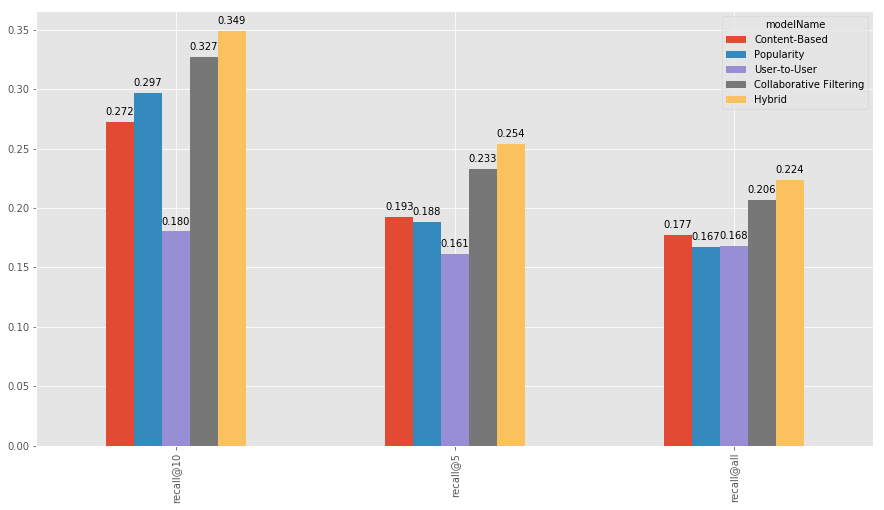

In [132]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [133]:
pop_summary['model'] = 'popularity'
cb_summary['model'] = 'content based'
ucf_summary['model'] = 'user to user'
cf_summary['model'] = 'collaborative filtering'
hybrid_summary['model'] = 'hybrid'

total_summary = pop_summary.append([cb_summary, ucf_summary, cf_summary, hybrid_summary])
total_summary

,order,interaction_category,_person_id,recall@10,recall@5,recall@all,interacted_in_test_avg,model
0,1,1,257,0.303502,0.221790,0.229572,1.000000,popularity
1,2,2,24,0.375000,0.291667,0.250000,1.000000,popularity
2,3,3 to 5,307,0.289902,0.198697,0.182410,1.000000,popularity
3,4,6 to 10,121,0.359504,0.247934,0.202479,1.595041,popularity
4,5,11 to 50,88,0.268105,0.163533,0.146677,4.431818,popularity
5,6,More than 50,36,0.302778,0.158333,0.122222,10.000000,popularity
0,7,Total,833,0.296538,0.188112,0.167211,1.837935,popularity
0,1,1,257,0.303502,0.221790,0.229572,1.000000,content based
1,2,2,24,0.333333,0.250000,0.250000,1.000000,content based
2,3,3 to 5,307,0.332248,0.250814,0.218241,1.000000,content based


In [134]:
tot = total_summary.pivot_table(index = ['order', 'interaction_category'], columns = 'model', values = 'recall@10')
tot.index = tot.index.get_level_values(1)
tot

model,collaborative filtering,content based,hybrid,popularity,user to user
interaction_category,,,,,
1,0.303502,0.303502,0.303502,0.303502,0.303502
2,0.291667,0.333333,0.291667,0.375000,0.250000
3 to 5,0.351792,0.332248,0.410423,0.289902,0.185668
6 to 10,0.388430,0.293388,0.421488,0.359504,0.231405
11 to 50,0.318669,0.266937,0.345752,0.268105,0.156070
More than 50,0.297222,0.208333,0.305556,0.302778,0.105556
Total,0.327237,0.272371,0.348792,0.296538,0.180274


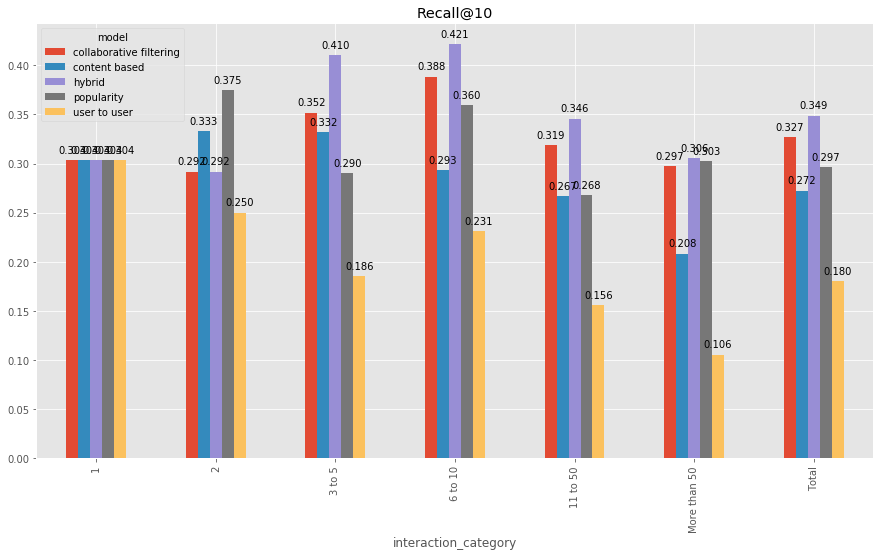

In [135]:
%matplotlib inline
ax = tot.plot(kind='bar', figsize=(15,8))
ax.title.set_text('Recall@10')
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [136]:
tot = total_summary.pivot_table(index = ['order', 'interaction_category'], columns = 'model', values = 'recall@all')
tot.index = tot.index.get_level_values(1)
tot

model,collaborative filtering,content based,hybrid,popularity,user to user
interaction_category,,,,,
1,0.229572,0.229572,0.229572,0.229572,0.229572
2,0.166667,0.250000,0.208333,0.250000,0.250000
3 to 5,0.221498,0.218241,0.267101,0.182410,0.185668
6 to 10,0.235537,0.202479,0.305785,0.202479,0.231405
11 to 50,0.191955,0.176114,0.203950,0.146677,0.156070
More than 50,0.188889,0.113889,0.186111,0.122222,0.105556
Total,0.206401,0.177008,0.224037,0.167211,0.167864


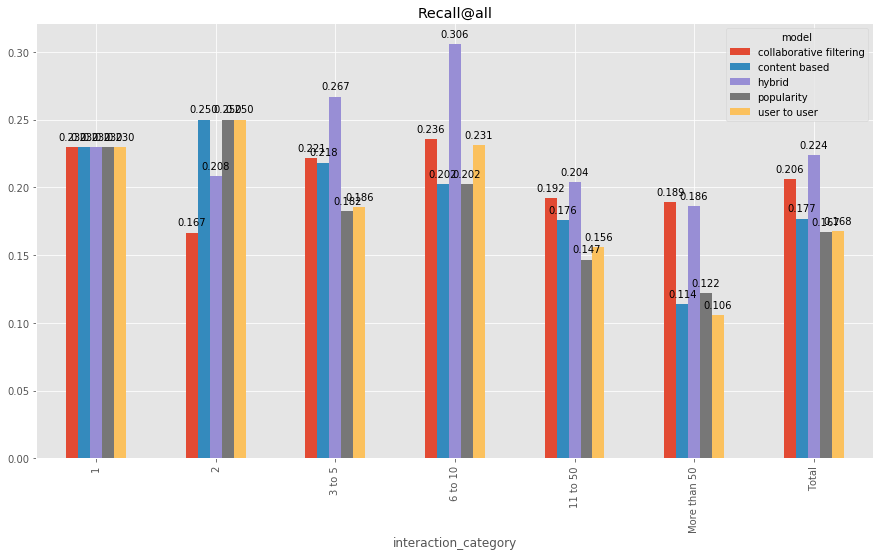

In [137]:
%matplotlib inline
ax = tot.plot(kind='bar', figsize=(15,8))
ax.title.set_text('Recall@all')
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [138]:
popularity_model.recommend_items(user_id = 'dummy', items_to_ignore=[], topn=10, verbose=False)

,contentId,eventStrength
0,5eb4f43d63c2df0022d975b8,141.070747
1,5ebb8db54b04f6003dd86570,140.049821
2,5e782cd3ea7e440022515910,117.255353
3,5ea2c5e5d4abf40029d88e2f,110.661180
4,5eb64ff240ca75004c486c14,81.650041
5,5eb39dc7854ebb0022622aa0,73.061326
6,5eb78f0117e19d00491830ab,65.920599
7,5eb23edc7056fb002fab0c65,65.753619
8,5ea153885738810038814fcf,61.772765
9,5eafced11fd841002e2c9c15,57.071194


In [139]:
item_popularity_df.head(10)

,contentId,eventStrength
0,5eb4f43d63c2df0022d975b8,141.070747
1,5ebb8db54b04f6003dd86570,140.049821
2,5e782cd3ea7e440022515910,117.255353
3,5ea2c5e5d4abf40029d88e2f,110.661180
4,5eb64ff240ca75004c486c14,81.650041
5,5eb39dc7854ebb0022622aa0,73.061326
6,5eb78f0117e19d00491830ab,65.920599
7,5eb23edc7056fb002fab0c65,65.753619
8,5ea153885738810038814fcf,61.772765
9,5eafced11fd841002e2c9c15,57.071194
